In [1]:
# Start
import os
import time
print("last time run: {}".format(time.strftime("%c")))
CWD = os.getcwd()
print("Current working dir: {}".format(CWD))

last time run: Thu Mar 28 21:53:42 2019
Current working dir: /home/bren/Home/python/Algorithms/skimage


In [2]:
# Style
from IPython.core.display  import HTML
from IPython.core.debugger import set_trace

def css_styling():
    styles = open("/home/bren/Home/python/Jupyter/Jupyter Notebooks/custom.css", "r").read()
    return HTML(styles)
css_styling()


In [3]:
# imports
from matplotlib import pyplot as plt, rcParams
import matplotlib.patches as mpatches

import numpy as np

from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

%matplotlib inline
plt.style.use("ggplot")
rcParams["figure.figsize"] = (14, 7)

import IPython, platform
%reload_ext watermark
print("Python  {}".format(platform.python_version()))
%watermark -v -m -p IPython,matplotlib,numpy,pandas,scipy,skimage


Python  3.7.1
CPython 3.7.1
IPython 7.1.1

IPython 7.1.1
matplotlib 3.0.2
numpy 1.16.1
pandas 0.23.4
scipy 1.2.1
skimage 0.14.2

compiler   : GCC 7.3.0
system     : Linux
release    : 4.9.0-8-amd64
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit


# Measuring Heterogenaity of Regions in an Image

___Musings of an Image Processing Dabbler___


Ray M. posed an interesting question for Nashville data nerds: how to measure homogenaity of atom distributions in an image. This notebook captures some of what I found working on that intriguing problem. As suggested by Rob H., one approach is to consider image processing algorithms. This work suggests some way forward in that regard.

The approach begins with preparing the images to enhance borders between the two atom types. Each image portrays individual images as red or blue (presumably only two different elements occur in this material). So,

* remove the shading used to make each atom appear 3D with a combination of high-pass filtering, gaussian filtering, and convolution. Note that the rgb values required limiting to the interval [0,255] in order to display the high-pass filter output.
* prepare a gray-scale image for the primary object detection algorithm by isolating the rgb image's red and blue layers and setting red layer pixles to 0 where red layer value is less than blue layer value.

After trying several skimag.segmentaion algorithms, the [otsu_threshold](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py) method was selected for both speed of processing and for ease of counting the objects detected. For further discussion, see [this](https://en.wikipedia.org/wiki/Otsu's_Method) reference.

Finaly, a plot of unique values in red, green, and blue layes after the high-pass filter show different patterns in the homogeneous image versus the heterogenous image. I made no attempt to formulate a metric based on this difference.

### Further possible research

I believe these images are single slices of a three-dimensional sample a material. If so, then the image process demonstrated herein are limited to two-dimensional images of 1,000 by 1,000 rgb pixels each. Even if each pixel represented a single atom (which it does not). a 1,000 X 1,000 slice of atoms is probably pretty small. Maybe size doesn't matter, but computationally, even an rgb model of a 1,000 x 1,000 x 1,000 particle of mass would present processing difficulties in terms of memory and cpu time. Even if we restricticted ourselves to 2 element material and replaced the rgb model with binary values (0 == element 1, 1 == element 2), this is still a gigabyte of data. Assuming greater dilution of one element versus the other in a two element substance, the sample size could grow exponentially greater exacerbating the memory and computing power required. Some form buffering would most likely be required to solve the memory limitation but that would no doubt extend the compute.

Regardless, my thougts went to the rules used for that old computer "game of life" implemented by a program that traverses a matrix (albeit 2D) and essentially applies a convolution to each location to determe if a "cell" had sufficient neighbors to "survive" and/or multiply (I'm a bit foggy on the precise rule). It seems to me that a similar convolutional approach could be used to detect boundaries around a location in 3D but in this case it would be a 3D convolution. Armed with such an algorithm, something like [particle swarms](https://www.youtube.com/watch?v=gkGa6WZpcQg&t=21s) could be used to trace the contours of atom clusters where, rather than sharing best maxima / minima, each particle shares countours found and, when a two particles detect the same boundary point, one changes the search direction leaving the other to finish tracing the boundary in whatever dimension it was tracing.

<a id='Table_of_Contents'></a> 
### Table of Contents

[Load Images](#Load_Images)

[Enhance Borders](#Enhance_Borders)

[Otsu Object Detection Method](#Otsu_Object_Detection_Method) - quick

[Red Green Blue Distributions](#Red_Green_Blue_Distributions)


## Load Images
<a id='Load_Images'></a>


[Table of Contents](#Table_of_Contents)

In [4]:
hetero = imread('Heterogenous.png')
hetero.__class__

numpy.ndarray

In [5]:
homo = imread('Homogenous.png')
homo.__class__

numpy.ndarray

In [6]:
hetero.shape, homo.shape

((1000, 1000, 3), (1000, 1000, 3))

## Enhance Borders
<a id='Enhance_Borders'></a>


[Table of Contents](#Table_of_Contents)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


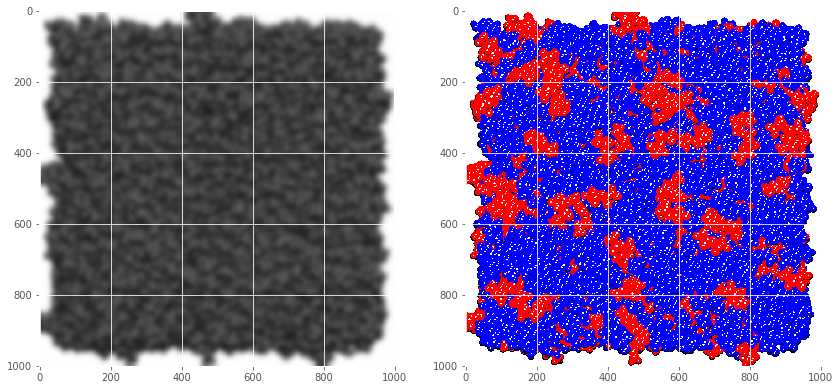

In [7]:
# a High-Pass Filter and Blurred
sigma = 8  # Standard deviation in pixels - TODO - calculate this rather than estimate
unsharp_strength = 0.8 # TODO - experiment with this value

def highPassAndBlurred(image, sigma=8, unsharp_strength=0.8):
    b = gaussian_filter(hetero, sigma)
    hp = image - unsharp_strength * b
    return hp, b

highpass, blurred = highPassAndBlurred(hetero)

rcParams["figure.figsize"] = (14, 7)

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(blurred, vmin=0, vmax=1)
axes[1].imshow(highpass, vmin=0, vmax=1)
plt.show()

In [8]:
kernel_size = 9
kernel = np.ones((kernel_size, kernel_size)) / kernel_size
kernel[0,:]

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [9]:
def convolveImage(image, kernel):
    def scaleIt(cvld):
        cvld[cvld > 255.0] = 255.0
        cvld[cvld < 0.0] = 0.0
        return cvld
    convolved = np.ones(image.shape)
    for i in range(convolved.shape[-1]):
        cvld = convolve2d(image[:,:,i], kernel, boundary='fill', mode='same',
                          fillvalue=0.)
        convolved[:,:,i] = scaleIt(cvld)

    plt.imshow(convolved.astype(int))
    return convolved.astype(int)


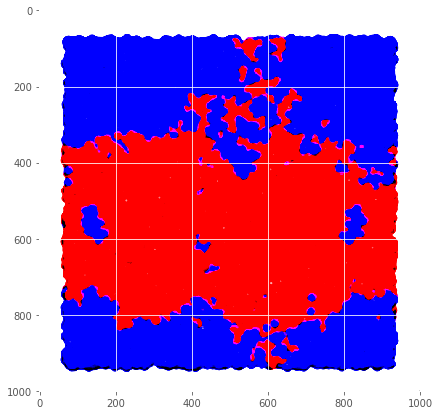

In [10]:
blurred = gaussian_filter(homo, sigma=8.)
rcParams["figure.figsize"] = (14, 7)

convolved_homo = convolveImage(homo - unsharp_strength * blurred, kernel)
plt.savefig('convolved_homo.png')


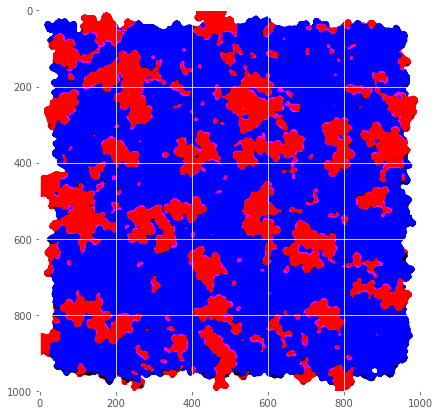

In [11]:
blurred = gaussian_filter(hetero, sigma=8.)
convolved_hetero = convolveImage(hetero - unsharp_strength * blurred, kernel)
plt.savefig('convolved_hetero.png')


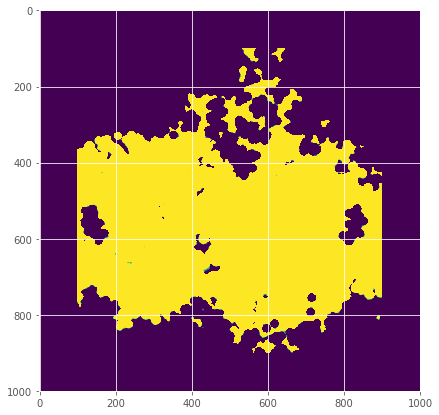

In [12]:
# zero in regions where blue > red leaving red only
gray_homo = convolved_homo[:,:,0]
gray_homo[homo[:,:,2] > homo[:,:,0]] = 0

# fill borders so interior objects have clear borders
gray_homo[:,:100] = 0
gray_homo[:,-100:] = 0
gray_homo[:100,:] = 0
gray_homo[-100:,:] = 0
    
plt.imshow(gray_homo)

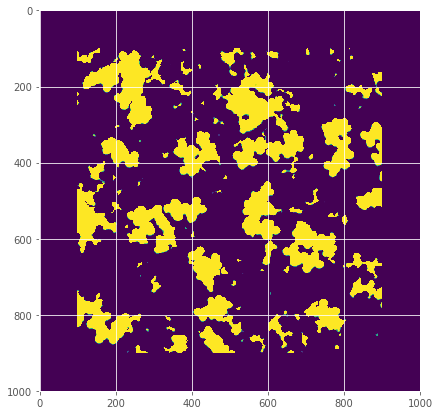

In [13]:
# zero in regions where blue > red leaving red only
gray_hetero = convolved_hetero[:,:,0]
gray_hetero[hetero[:,:,2] > hetero[:,:,0]] = 0

# fill borders so interior objects have clear borders
gray_hetero[:,:100] = 0
gray_hetero[:,-100:] = 0
gray_hetero[:100,:] = 0
gray_hetero[-100:,:] = 0

plt.imshow(gray_hetero)

## Otsu Object Detection Method
<a id='Otsu_Object_Detection_Method'></a>


[Table of Contents](#Table_of_Contents)

In [14]:
image = gray_hetero

def otsuODM(image):

    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(3))

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)
    image_label_overlay = label2rgb(label_image, image=image)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 100:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    return regionprops(label_image)


/home/bren/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


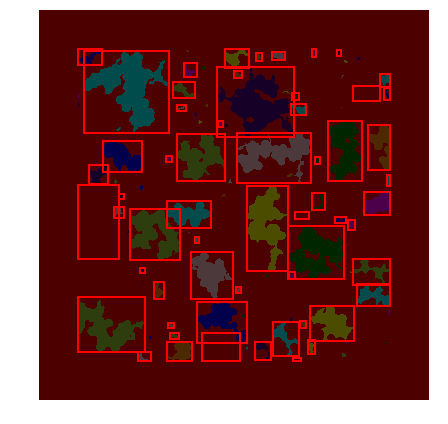

100 objects
CPU times: user 1.64 s, sys: 32 ms, total: 1.68 s
Wall time: 419 ms


In [15]:
%%time
hetero_objects = otsuODM(gray_hetero)
print('{:,d} objects'.format(len(hetero_objects)))


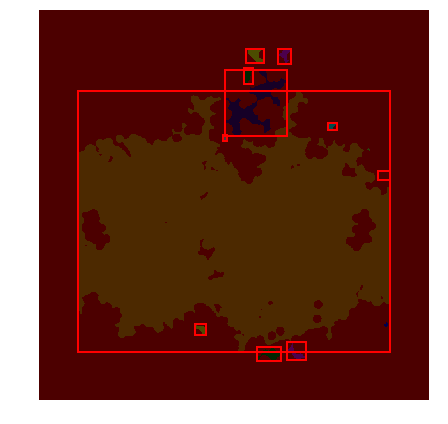

14 regions
CPU times: user 1.44 s, sys: 12 ms, total: 1.45 s
Wall time: 364 ms


In [16]:
%%time
homo_objects = otsuODM(gray_homo)
print('{:,d} regions'.format(len(homo_objects)))


### Are there more objects in the heterogenous image than in the homogenous image?

In [17]:
print('There {} more images in the heterogenous image'.format('ARE' if len(hetero_objects) > len(homo_objects)
                                                              else 'ARE NOT'))

There ARE more images in the heterogenous image


## Red Green Blue Distributions
<a id='Red_Green_Blue_Distributions'></a>

Not sure this could be the basis of a metric but the distributions are clearly different.

[Table of Contents](#Table_of_Contents)

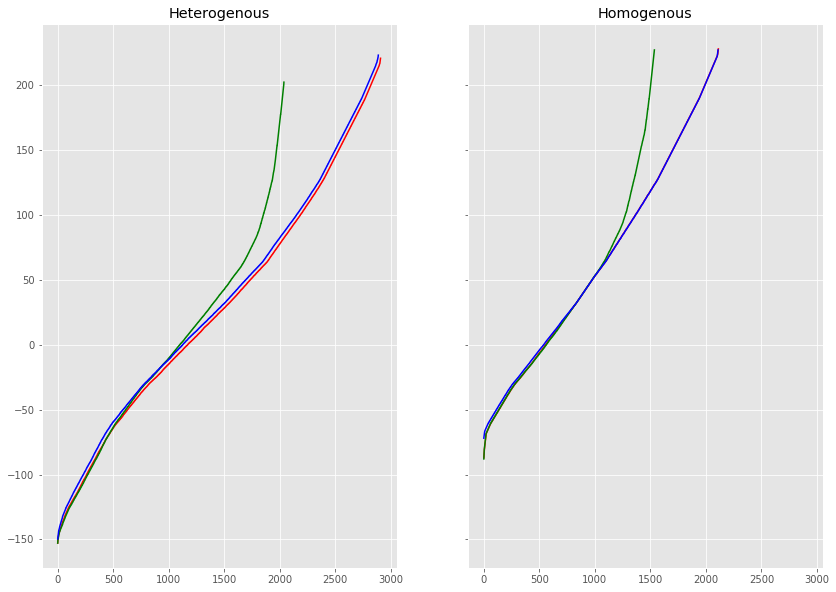

In [18]:
# plot red from RGB for hetero and homo
hetero = imread('Matsumato Heterogenous.png')
homo = imread('Matsumato Homogenous.png')
plt.close('all')

blurred = gaussian_filter(hetero, sigma=8.)

fig, axes = plt.subplots(ncols=2, figsize=(14,10), sharex=True, sharey=True)

axes[0].set_title("Heterogenous")
highpass, blurred = highPassAndBlurred(hetero)
for c, i in zip('red green blue'.split(' '), range(hetero.shape[-1])):
    axes[0].plot(np.unique(highpass[:,:,i]), color=c)

axes[1].set_title("Homogenous")
highpass, blurred = highPassAndBlurred(homo)
for c, i in zip('red green blue'.split(' '), range(homo.shape[-1])):
    axes[1].plot(np.unique(highpass[:,:,i]), color=c)
